# Transfer Learning, Unsupervised Learning, Custom Loss functions, Generative Modelling

In this notebook we're going to look at some broader/slightly more advanced concepts. This will include:

1.   Using transfer learning on a pre-trained model
2.   Unsupervised learning
3.   Custom loss functions
4.   Generative Modelling with VAEs

As usual, please take a copy of this notebook before executing to preserve GPU resources.

You may need to switch the runtime to the GPU as before.


In [ ]:
!pip3 install torch torchaudio torchvision torchtext torchdata scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Transfer Learning

Transfer learning allows us to take pre-trained neural networks, and re-train them on a similar task, usually much faster and at a lower computational cost than it would take to train the original network from scratch.

This allows us to leverage powerful architectures, trained on hundreds of thousands of images, on new problems which might have much less available training data.

Often the transfer learning process takes the following form:

1. Take an existing network, and freeze all network weights aside from the last layer (or layers). This prevents those weights changing during training - preserving the networks original knowledgebase.
2. Attach an appropriate output layer matching the number of classes in our problem (or regression, etc).
3. Train the network on our problem.
4. Evaluate as usual.

We'll experiment with this using ResNet18 (pre-trained on Imagenet) and the [Places365](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Places365.html) dataset

In [ ]:
# Set up some useful imports.

%matplotlib inline
# Unless you're running in a notebook, ignore the above line.

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms

365
7300


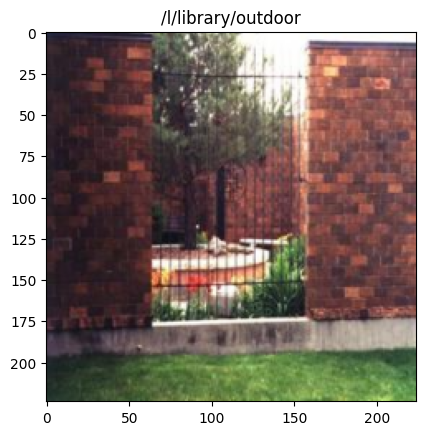

In [ ]:
# Set up the dataset we want to transfer learn upon.
from torch.utils.data import random_split


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))])

# We'll use the validation set for training, as the training set is very large.
dataset = torchvision.datasets.Places365('.', small=True, split="val", transform=transform, download=True)

# Cut the dataset down further, for the purposes of example
data_splits = random_split(dataset, [0.2, 0.1, 0.7])
training_set = data_splits[0]

test_set = data_splits[1]

places_classes = dataset.classes

# Large batch size to speed training - we have 16Gb of GPU RAM, might as well use it.
training_loader = torch.utils.data.DataLoader(training_set, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=True)

# Check some training examples
x, y = training_set[5]

# Determine how many classes there are
print(len(dataset.classes))
print(len(training_set))

npimg = x.numpy()
npimg = np.squeeze(npimg)
# Swap the channel dimension to the last dim, which matplotlib expects.
npimg = np.transpose(npimg, axes=(1, 2, 0))
plt.title(places_classes[y])
plt.imshow(npimg)
plt.show()

Epoch 0 loss: 6.036894989013672
Epoch 1 loss: 5.745605023701986
Epoch 2 loss: 5.4745687484741214
Epoch 3 loss: 5.213858000437418
Epoch 4 loss: 4.970567131042481
Epoch 5 loss: 4.752481810251871
Epoch 6 loss: 4.5422340075174965
Epoch 7 loss: 4.350048923492432
Epoch 8 loss: 4.17364075978597
Epoch 9 loss: 4.0090203444163
Epoch 10 loss: 3.864855480194092
Epoch 11 loss: 3.7224130471547445
Epoch 12 loss: 3.5998231569925943
Epoch 13 loss: 3.477934710184733
Epoch 14 loss: 3.383812650044759
Epoch 15 loss: 3.2756758371988934
Epoch 16 loss: 3.1852636973063153
Epoch 17 loss: 3.089018948872884
Epoch 18 loss: 3.009258492787679
Epoch 19 loss: 2.930355596542358
Epoch 20 loss: 2.859790023167928
Epoch 21 loss: 2.7953771273295085
Epoch 22 loss: 2.71870813369751
Epoch 23 loss: 2.666864824295044
Epoch 24 loss: 2.607586208979289


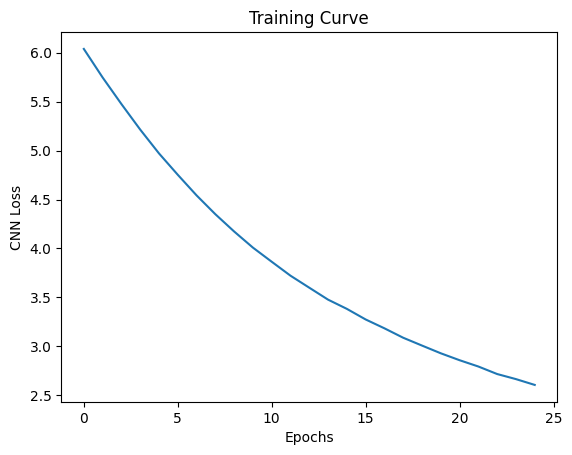

In [ ]:
# Load and set-up the model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the model weights
for param in model.parameters():
    param.requires_grad = False

# Resnet models have an fc variable defined on the class which defines the
# fully connected output layer

# Get the number of input features of the existing layer
num_ftrs = model.fc.in_features

# Set the instance variable to a new Linear layer, with the correct number of
# inputs and outputs
model.fc = torch.nn.Linear(num_ftrs, 365)

# Training the model is no different than we've already seen

model = model.to('cuda')

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epoch_losses = []

# The model requires a fair bit of training
# Can reduce this to avoid waiting a long time - at cost of accuracy.
EPOCHS = 25

for epoch in range(0, EPOCHS):
  epoch_loss = 0
  # Run in a loop for n epochs
  for idx, data in enumerate(training_loader):
    inputs, labels = data

    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # Print the loss (normalised by total batches)
  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  epoch_losses.append(epoch_loss / len(training_loader))

plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("CNN Loss")
plt.title("Training Curve")
plt.show()

Evaluate how well the transfer-learned network performs.

In [ ]:
model.eval()
total_correct = 0
all_y = np.array([])
all_labels = np.array([])

for idx, data in enumerate(test_loader):
  inputs, labels = data
  # Don't forget to copy the data to the GPU

  inputs = inputs.to('cuda')
  labels = labels.to('cuda')

  # Forward pass
  outputs = model(inputs)

  # The greatest value in the vector represents the class
  # Find the index of this value and compare to the ground truth
  correct_output_vector = (labels == torch.argmax(outputs, axis=1))
  # Sum over all correct in the batch
  batch_correct = torch.sum(correct_output_vector)
  # Detach from Pytorch (not strictly necessary but easier to work with)

  # Use .cpu() to move the tensor back from the gpu to the cpu to process with numpy
  batch_correct = batch_correct.cpu().numpy()

  # Store all the labels and predictions for some downstream analysis.
  all_y = np.concatenate((all_y, torch.argmax(outputs.cpu(), axis=1).numpy()))
  all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

  total_correct += batch_correct

# The accuracy might not be high, but remember, there's 365 different classes,
# and we're only training one layer for a few minutes.
accuracy = (total_correct / len(test_set)) * 100
print(f"Accuracy: {np.round(accuracy, 2)}%")

Accuracy: 24.16%


## Exploration

1. Try re-using the ResNet18 model, but with no pre-set weights (set `weights='IMAGENET1K_V1'` to `weights=None` when initialising the network). What accuracy can you achieve? Over how long?
2. Try the alternate fine-tuning method, which does not freeze any weights. How well does this work?
3. Try writing your own CNN for the places365 dataset (or the subset we're using here) - what performance can you get?

# Unsupervised Learning

Unsupervised learning allows you to train neural networks in cases where there **are no ground-truth labels**.

In an ideal case, the neural network automatically learns the structure of the data, and may reveal relationships within the dataset that are not immediately obvious.

We'll take a look at this idea with one type of unsupervised architecture: autoencoders.

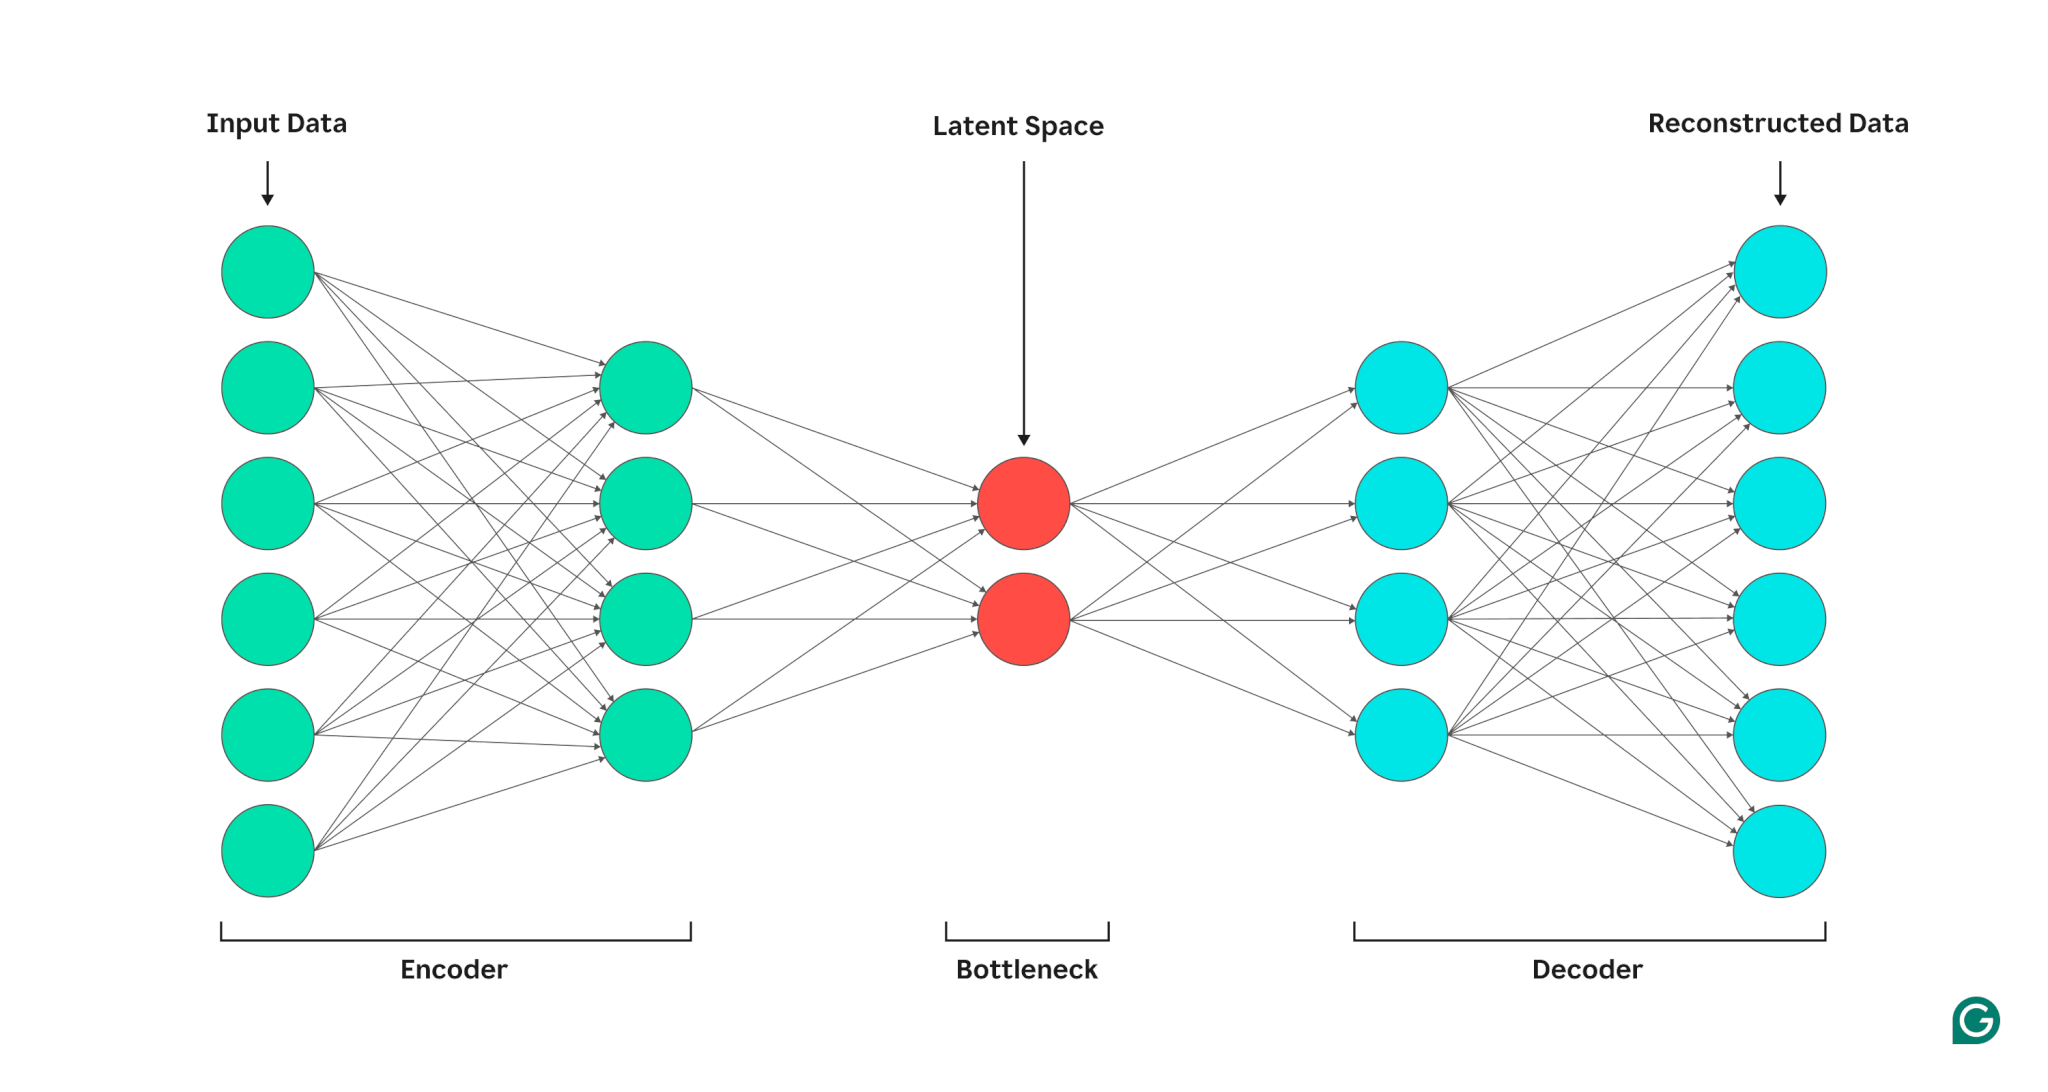

Autoencoders start from the input data, learn an efficient, low-dimensionality encoding, and then learn to reconstruct the original input from this encoding.

This is effectively a learned form of dimensionality reduction.

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
# Set up the data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split

transform = transforms.Compose(
    [transforms.ToTensor()])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)

# Split off a part of the training set to perform visualisation on, later.
# This isn't a true "test" set.
test_set = random_split(training_set, [0.15, 0.85])[0]
class_labels = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_loader = torch.utils.data.DataLoader(training_set, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.80MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 134kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.43MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.8MB/s]


In [ ]:
# Define an autoencoder network

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    # We'll use PyTorch's sequential container to hold modules
    # Sequential defines a series of layers which are called in order
    # The output of each previous layer is fed as input to the next one in sequence

    # Convert the input into an 8-dimensional latent code
    self.encoder = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8))

    # Convert the latent code into an image.
    self.decoder = nn.Sequential(
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 784),
        # Map the output back to between 0 and 1.0
        nn.Sigmoid())

  def encode(self, batch):
    batch = batch.view(-1, 28 * 28)
    enc = self.encoder(batch)
    return enc

  def forward(self, batch):
    enc = self.encode(batch)
    dec = self.decoder(enc)

    dec = dec.view(-1, 1, 28, 28)
    return dec


model = AutoEncoder()

# Check the forward pass.
random_data = torch.rand((4, 1, 28, 28))
random_out = model(random_data)
print(random_out.shape)

torch.Size([4, 1, 28, 28])


Epoch 0 loss: 0.09809820890679198
Epoch 1 loss: 0.047042263924317845
Epoch 2 loss: 0.03847218696343697
Epoch 3 loss: 0.035690464584504145
Epoch 4 loss: 0.03360971691623583
Epoch 5 loss: 0.031178165858579895
Epoch 6 loss: 0.02945413404160132
Epoch 7 loss: 0.02790260325990996
Epoch 8 loss: 0.026893130787727187
Epoch 9 loss: 0.026215301889736774
Epoch 10 loss: 0.025820080396103656
Epoch 11 loss: 0.025383058730197156
Epoch 12 loss: 0.025056330865975154
Epoch 13 loss: 0.024804220850563656
Epoch 14 loss: 0.024619422868778138
Epoch 15 loss: 0.024425607079924163
Epoch 16 loss: 0.02421509689193661
Epoch 17 loss: 0.024140312383740634
Epoch 18 loss: 0.023959458931901698
Epoch 19 loss: 0.023796818676893993


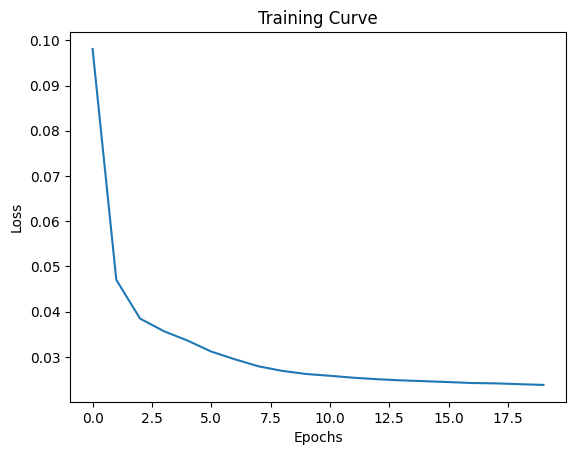

In [ ]:
# Now we just need to train the model.

# This time, we'll use Mean Squared Error to measure the difference between reconstruction
# and ground truth.
loss_fn = nn.MSELoss()

# Use Adam.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8)


epochs = 20
losses = []

model = model.to("cuda")

for epoch in range(epochs):
  epoch_loss = 0

  for images, _ in training_loader:
      images = images.to("cuda")
      optimizer.zero_grad()

      # Note that we're throwing away the labels here
      reconstructed = model(images)

      loss = loss_fn(reconstructed, images)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  losses.append(epoch_loss / len(training_loader))

plt.plot(range(0, len(losses)), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

In [ ]:
# Check reconstruction
import numpy as np

# Try changing this to see the effect on various ground-truth images.
image, label = test_set[0]

image = torch.unsqueeze(image, 0)
image_cuda = image.to("cuda")
recon = model(image_cuda)

recon = torch.squeeze(recon, 0)
recon = recon.detach().cpu().numpy()
recon = np.transpose(recon, (1, 2, 0))

image = torch.squeeze(image, 0)
image = np.transpose(image, (1, 2, 0))

combined = np.hstack([recon, image])
plt.imshow(combined, cmap='gray')
plt.title("Reconstructed --- Original")
plt.show()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

1. What do you notice about the reconstruction?
2. If you change the latent space - what effect does this have, if any?

It appears the neural network has learned to reconstruct (to some degree) the input images by way of an 8 dimensional latent space.

We can visualise this space to try and understand what the neural network has learned.

We'll use t-SNE to convert the 8-dimensional latent space into a two-dimensional representation we can visualise.

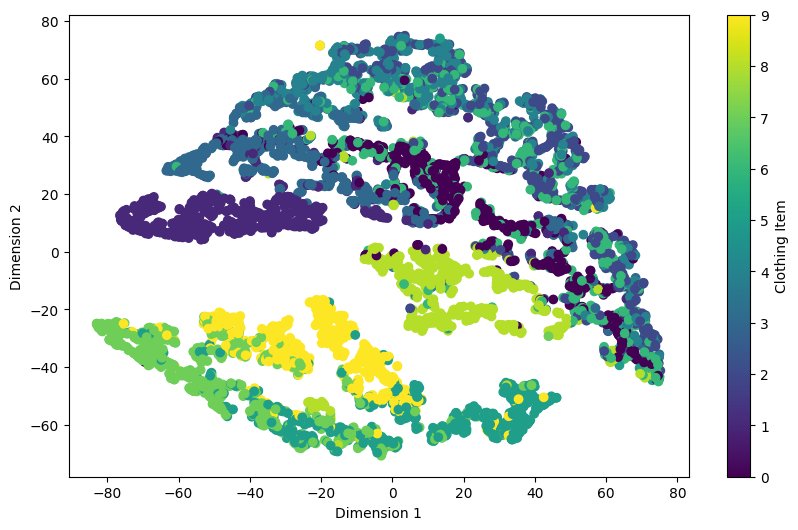

In [ ]:
from sklearn.manifold import TSNE

# Extract features using the autoencoder models encoder
model = model.to("cuda")
targets = []
with torch.no_grad():
   features = []
   for images, label in test_loader:
       images = images.to("cuda")
       targets.append(label.numpy())
       encoded = model.encode(images)
       features.append(encoded.view(encoded.size(0), -1).cpu().numpy())
features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)

# T-SNE 8 -> 2
# T-SNE preserves local similarity between samples.
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
tsne_features = tsne.fit_transform(features)

# Plot the TSNE results with label
plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=targets, cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Clothing Item')
plt.show()

# Custom Loss Functions

While PyTorch comes with a vast array of built-in loss functions, it is also possible to write your own, with any constraints you might wish to place inside them.

Crucially, the loss function must be *differentiable* or the network will not be able to be trained.

In [ ]:
# Writing a loss function works much the same as writing a neural network
# We inherit from nn.Module

# However, we only need to define a forward function.

# As an example, we can re-implement the mean squared error loss.
class CustomMSELoss(nn.Module):
  def __init__(self):
    super(CustomMSELoss, self).__init__()

  # Define a function which takes two parameters:
  # The inputs, and the targets.
  def forward(self, inputs, targets):
    loss = torch.mean(torch.pow(inputs - targets, 2))

    return loss


In [ ]:
# We can test this out with our autoencoder above, like so:



# Use the rewritten loss function
loss_fn = CustomMSELoss()

epochs = 20
losses = []

custom_loss_model = AutoEncoder()
custom_loss_model = custom_loss_model.to("cuda")

optimizer = torch.optim.Adam(custom_loss_model.parameters(), lr=0.001, weight_decay=1e-8)

for epoch in range(epochs):
  epoch_loss = 0

  for images, _ in training_loader:
      images = images.to("cuda")
      optimizer.zero_grad()

      # Note that we're throwing away the labels here
      reconstructed = custom_loss_model(images)

      loss = loss_fn(reconstructed, images)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  losses.append(epoch_loss / len(training_loader))

plt.plot(range(0, len(losses)), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

NameError: name 'CustomMSELoss' is not defined

# Generative Modelling

We can bring the above concepts together with a **variational** [autoencoder](https://en.wikipedia.org/wiki/Variational_autoencoder).

These have quite a heavy theoretical background. However, the implementation is relatively straightforward.

A normal autoencoder maps each input sample to a single point in the latent space. This means spaces in-between those points are undefined.

A variational autoencoder maps each sample to a distribution - which means the latent space is continuous, and as such, many points from across the space can be used to generate output.

This makes the model *generative* - in that new data can be produced.

In [ ]:
class VAE(nn.Module):
  def __init__(self, device):
    super(VAE, self).__init__()
    self.device = device

    # LeakyReLU for stability.

    self.encoder = nn.Sequential(
        nn.Linear(784, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 16),
        nn.LeakyReLU(0.2))

    # Loosely speaking: a VAE converts each sample into a gaussian distribution
    self.mean = nn.Linear(16, 8)
    self.var = nn.Linear(16, 8)

    # Convert the latent code into an image.
    self.decoder = nn.Sequential(
        nn.Linear(8, 16),
        nn.LeakyReLU(0.2),
        nn.Linear(16, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 784),
        # Map the output back to between 0 and 1.0
        nn.Sigmoid())

  def encode(self, batch):
    batch = batch.view(-1, 28 * 28)
    enc = self.encoder(batch)

    mean = self.mean(enc)
    var = self.var(enc)

    return mean, var

  def decode(self, z):
    dec = self.decoder(z)

    return dec

  def reparameterize(self, mean, var):
    """
    Randomly sample from the latent space.
    Practical effect: condition areas of the space to match the inputs.
    """
    epsilon = torch.randn_like(var).to(self.device)
    z = mean + torch.exp(0.5 * var) * epsilon
    return z

  def forward(self, batch):
    mean, var = self.encode(batch)
    z = self.reparameterize(mean, var)
    dec = self.decode(z)

    dec = dec.view(-1, 1, 28, 28)
    return dec, mean, var


model = VAE("cpu")

# Check the forward pass.
random_data = torch.rand((4, 1, 28, 28))
img, m, v = model(random_data)
print(img.shape)
print(m.shape)
print(v.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4, 8])
torch.Size([4, 8])


A VAE requires a custom loss function which combines a *reconstruction* error and a *probabilistic* error.

The reconstruction error tries to force the generated images to match the input images.

The probabilistic error tries to ensure the *distribution* of the inputs and the generated outputs match.

In [ ]:
# To train a variational autoencoder, we need a custom loss function.
# This is a combination of the reconstruction error between inputs and outputs,
# and the Kullbach-Leibler divergence enforces a prior distribution.

class VAELoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(VAELoss, self).__init__()

  def forward(self, inputs, targets, mean, var):
      reproduction_loss = nn.functional.binary_cross_entropy(targets, inputs, reduction='sum')
      KLD = -0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())

      return reproduction_loss + KLD

Found available device: cpu
Epoch 0 loss: 170443.3210076801
Epoch 1 loss: 140529.13880429024
Epoch 2 loss: 133697.35699152542
Epoch 3 loss: 130714.28300450213
Epoch 4 loss: 129462.90247616525
Epoch 5 loss: 128276.39916578389
Epoch 6 loss: 127578.09886453919
Epoch 7 loss: 127203.32777740996
Epoch 8 loss: 127210.13873808262
Epoch 9 loss: 126659.4760659428
Epoch 10 loss: 126460.63412010063
Epoch 11 loss: 126263.07337460275
Epoch 12 loss: 126172.59492518537
Epoch 13 loss: 126060.12685381356
Epoch 14 loss: 125956.26277807204
Epoch 15 loss: 125833.00748146187
Epoch 16 loss: 125745.58100503178
Epoch 17 loss: 125703.92867783368
Epoch 18 loss: 125697.62538069386
Epoch 19 loss: 125614.67885990466


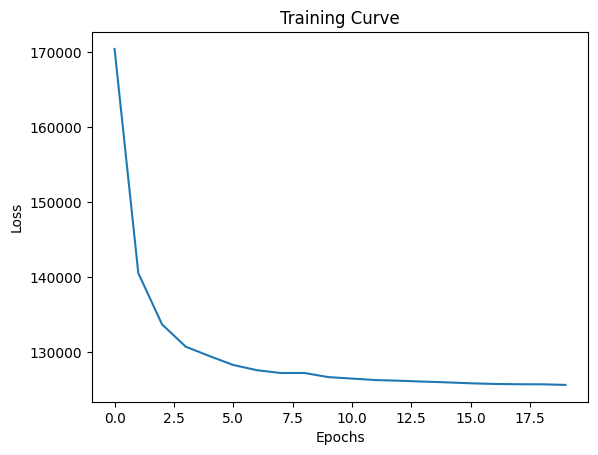

In [ ]:
# Training the model is much the same

loss_fn = VAELoss()

epochs = 20
losses = []

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Found available device: {device}")

vae_model = VAE(device)
vae_model = vae_model.to(device)

optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.01)

for epoch in range(epochs):
  epoch_loss = 0

  for images, _ in training_loader:
      images = images.to(device)
      optimizer.zero_grad()

      # Note that we're throwing away the labels here
      recon, m, v = vae_model(images)

      # Using our custom loss function
      loss = loss_fn(images, recon, m, v)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  losses.append(epoch_loss / len(training_loader))

plt.plot(range(0, len(losses)), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

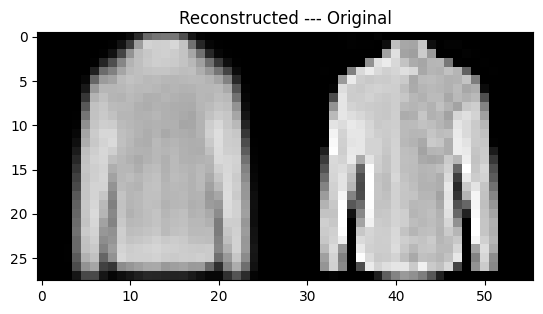

In [ ]:
# Check how well the VAE learned to reconstruct:

# Check reconstruction
import numpy as np

# Try changing this to see the effect on various ground-truth images.
image, label = test_set[8]

image = image.to("cuda")
image = torch.unsqueeze(image, 0)

vae_model = vae_model.to("cuda")
recon, _, _ = vae_model(image)

recon = torch.squeeze(recon, 0)
recon = recon.detach().cpu().numpy()
recon = np.transpose(recon, (1, 2, 0))

image = image.cpu()
image = torch.squeeze(image, 0)
image = np.transpose(image, (1, 2, 0))

combined = np.hstack([recon, image])
plt.imshow(combined, cmap='gray')
plt.title("Reconstructed --- Original")
plt.show()

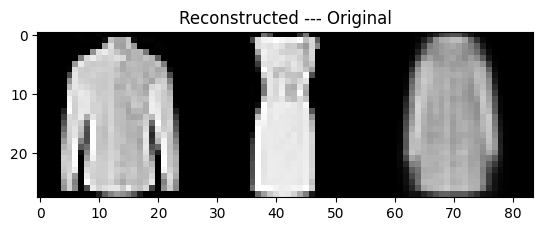

In [ ]:
# Or - generate something in-between

image1, _ = test_set[8]
image2, _ = test_set[344]

image1 = torch.unsqueeze(image1, 0)
image2 = torch.unsqueeze(image2, 0)

m1, v1 = vae_model.encode(image1)
m2, v2 = vae_model.encode(image2)

m3 = (m1 + m2) / 2
v3 = (v1 + v2) / 2

z = vae_model.reparameterize(m3, v3)
recon = vae_model.decode(z)
recon = torch.squeeze(recon, 0)
recon = recon.view(28, 28, 1)
recon = recon.detach().cpu().numpy()


image1 = torch.squeeze(image1, 0)
image2 = torch.squeeze(image2, 0)
image1 = np.transpose(image1, (1, 2, 0))
image2 = np.transpose(image2, (1, 2, 0))

#recon = np.transpose(recon, (1, 2, 0))
combined = np.hstack([image1, image2, recon])
plt.imshow(combined, cmap='gray')
plt.title("Reconstructed --- Original")
plt.show()

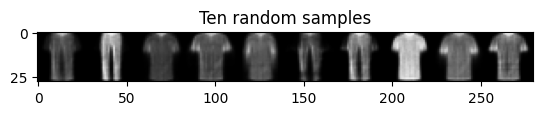

In [ ]:
# Or, plot something completely random drawn from the latent space

z = torch.rand((10, 8))
recon = vae_model.decode(z)
recon = recon.view(-1, 28, 28, 1)
images = []
for x in recon:
  images.append(x.detach().cpu().numpy())

combined = np.hstack(images)

plt.imshow(combined, cmap='gray')
plt.title("Ten random samples")
plt.show()

You might be able to improve the generative procedure by:

1. Increasing the size of the latent dimension from 8
2. Increasing training times / changing learning rate / number of epochs
3. Deepening the network (both encoder and decoder).